In [1]:
import os
import torch
import pprint
import random
import warnings
import numpy as np
from PIL import Image
from uuid import uuid4
from pathlib import Path
from einops import rearrange
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pdf2image import convert_from_path
from dataclasses import asdict, dataclass
from huggingface_hub import notebook_login
from qwen_vl_utils import process_vision_info
from colpali_engine.interpretability.vit_configs import VIT_CONFIG
from colpali_engine.interpretability.processor import ColPaliProcessor
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.image_from_page_utils import load_from_dataset
from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.utils.image_utils import scale_image,get_base64_image
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.interpretability.plot_utils import plot_patches, plot_attention_heatmap
from colpali_engine.interpretability.torch_utils import normalize_attention_map_per_query_token

warnings.simplefilter('ignore')
notebook_login(new_session=False)

User is already logged in.


In [2]:
wd = os.path.dirname(os.getcwd())
os.chdir(wd)
print(f'path: {wd}') 

path: /home/dgarieck23/VLMs/tunnel_vision


In [3]:
from src.utils.utils import *

### Leveraging GPU for Perfomance
To optimize performance, we'll use GPU accelaration if available

In [4]:
device = get_device()

GPU is available
GPU name: NVIDIA GeForce RTX 4090 Laptop GPU


#### Set Seed

In [5]:
seed = 42
random.seed(seed)              # Python's built-in random module
np.random.seed(seed)           # NumPy
torch.manual_seed(seed)        # PyTorch
torch.cuda.manual_seed(seed)   # For GPU computations in PyTorch
torch.cuda.manual_seed_all(seed)  # If you're using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Pdf to Image

In [6]:
pdf_file = {
    'path':'data/raw/7eleven Valueact.pdf', 'title':'Transforming Seven & i Holdings into Global Champion 7-Eleven', 'author':'Valueact', 'date':'February 2022'
}

images = convert_from_path(pdf_file['path'], dpi=200, thread_count=6)

### ColPali: Efficient Document Retrieval with Vision Language Models

In [7]:
model_name = 'vidore/colpali-v1.2'

model = ColPali.from_pretrained('google/paligemma-3b-mix-448', torch_dtype=torch.bfloat16, device_map=device).eval()
model.load_adapter(model_name)
model.to(device)
processor = AutoProcessor.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
embeddings = []

dataloader = DataLoader(
    images,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: process_images(processor, x)
)

In [9]:
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

100%|██████████| 38/38 [00:12<00:00,  3.06it/s]


In [10]:
pdf_file['images'] = images
pdf_file['embeddings'] = embeddings

#### Retrieval

In [11]:
queries = ['What kind of strategic initiatives are proposed?']
dummy_image = Image.new("RGB", (448, 448), (255, 255, 255))
dataloader = DataLoader(
    queries,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: process_queries(processor, x, dummy_image),
)

In [12]:
qs = []
for batch_query in tqdm(dataloader):
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
    qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))

100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


In [13]:
retriever_evaluator = CustomEvaluator(is_multi_vector=True)
scores = retriever_evaluator.evaluate(qs, pdf_file['embeddings'])
topk = np.argsort(scores)[0][::-1]

tensor([24])
Top 1 Accuracy (verif): 0.0


#### Interpretability

In [14]:
# sanity checks
if len(model.active_adapters()) != 1:
    raise ValueError("The model must have exactly one active adapter.")

if model.config.name_or_path not in VIT_CONFIG:
    raise ValueError("The model must be referred to in the VIT_CONFIG dictionary.")
vit_config = VIT_CONFIG[model.config.name_or_path]

In [16]:
# retrieve top k results from ColPali for a given query
k=1
query = queries[0]

input_image_square = []
for k in tqdm(topk[:k]):
    image = pdf_file['images'][k]
    input_image_square.append(image.resize((vit_config.resolution, vit_config.resolution)))    

100%|██████████| 1/1 [00:00<00:00, 92.60it/s]


In [17]:
# interpretability model
processor = ColPaliProcessor.from_pretrained('google/paligemma-3b-mix-448')

In [18]:
# preprocess the inputs
add_special_prompt_to_doc = True
input_text_processed = processor.process_text(query).to(model.device)

In [19]:
input_image_processed = []

for image in tqdm(input_image_square):
    input_image_processed.append(processor.process_image(image, add_special_prompt=add_special_prompt_to_doc).to(model.device))

100%|██████████| 1/1 [00:00<00:00, 131.31it/s]


In [20]:
# forward pass
with torch.no_grad():
    output_text = model.forward(**asdict(input_text_processed))  # (1, n_text_tokens, hidden_dim)

In [21]:
# NOTE: `output_image`` will have shape:
# (1, n_patch_x * n_patch_y, hidden_dim) if `add_special_prompt_to_doc` is False
# (1, n_patch_x * n_patch_y + n_special_tokens, hidden_dim) if `add_special_prompt_to_doc` is True

output_image = []

for image in tqdm(input_image_processed):
    with torch.no_grad():
        output_image.append(model.forward(**asdict(image)))

100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


In [22]:
processed_images = []

for image in tqdm(output_image):
    if add_special_prompt_to_doc:  # remove the special tokens
        image = image[
            :, : processor.processor.image_seq_length, :
        ]  # (1, n_patch_x * n_patch_y, hidden_dim)

    image = rearrange(
        image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
    )  # (1, n_patch_x, n_patch_y, hidden_dim)

    processed_images.append(image)            

100%|██████████| 1/1 [00:00<00:00, 109.03it/s]


In [23]:
attention_maps_normalized = []

for image in tqdm(processed_images):
    # get the unnormalized attention map
    attention_map = torch.einsum(
        "bnk,bijk->bnij", output_text, image
    )  # (1, n_text_tokens, n_patch_x, n_patch_y)
    attention_map_normalized = normalize_attention_map_per_query_token(
        attention_map
    )  # (1, n_text_tokens, n_patch_x, n_patch_y)
    attention_maps_normalized.append(attention_map_normalized.float())    

100%|██████████| 1/1 [00:00<00:00, 56.63it/s]


In [24]:
# get text token information
n_tokens = input_text_processed.input_ids.size(1)
text_tokens = processor.tokenizer.tokenize(processor.decode(input_text_processed.input_ids[0]))
print({idx:val for idx, val in zip(range(len(text_tokens)),text_tokens)})

{0: '<bos>', 1: 'What', 2: '▁kind', 3: '▁of', 4: '▁strategic', 5: '▁initiatives', 6: '▁are', 7: '▁proposed', 8: '?', 9: '\n'}


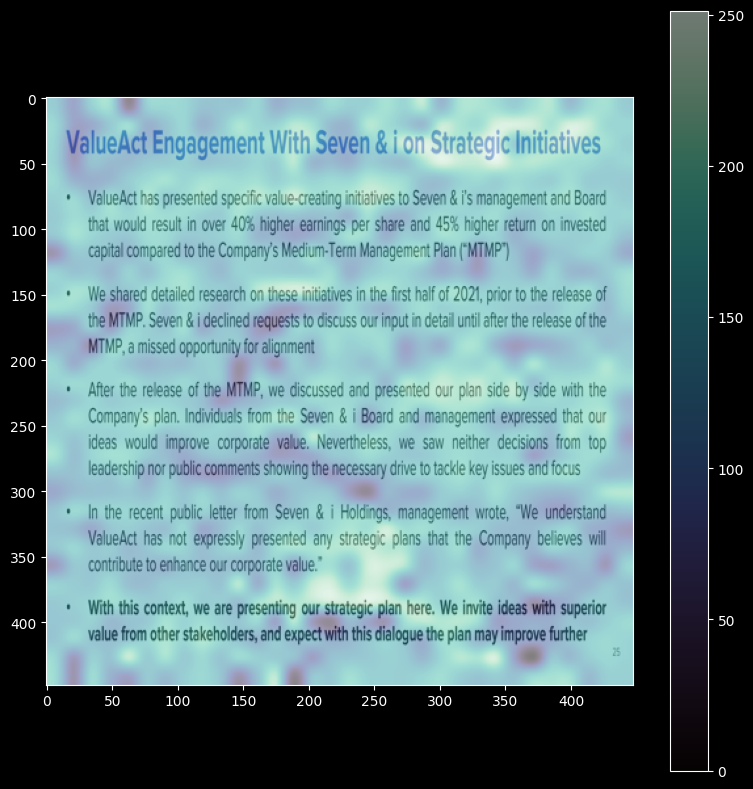

In [25]:
for idx in range(len(attention_maps_normalized)):
    fig,axis = plot_attention_heatmap(
        input_image_square[idx],
        vit_config.patch_size,
        vit_config.resolution,
        attention_maps_normalized[idx][0, [4,5], :, :].mean(dim=0),
        style="dark_background",
        show_colorbar=True,
        show_axes=True)
    fig.tight_layout()
    fig.show()

In [26]:
# to avoid OOM errors in the next part I'm removing components for ColPali
clear_gpu([model,processor])
clear_gpu([])

#### Augmented Generation with VLMs

In [27]:
vl_model = 'Qwen/Qwen2-VL-2B-Instruct'

In [28]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    vl_model, 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16,
    attn_implementation='flash_attention_2',
    device_map=device
).eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
processor = AutoProcessor.from_pretrained(vl_model, trust_remote_code=True)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": input_image_square[0]},
            #{"type": "image", "image": input_image_square[1]},
            #{"type": "image", "image": input_image_square[2]},                        
            {"type": "text", "text": query},
        ],
    }
]

In [31]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [32]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [33]:
generated_ids = model.generate(**inputs, max_new_tokens=150)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [36]:
pprint.pprint(output_text)

["ValueAct has presented specific value-creating initiatives to Seven & i's "
 'management and Board that would result in over 40% higher earnings per share '
 "and 45% higher return on invested capital compared to the Company's "
 'Medium-Term Management Plan ("MTMP").']
